# Libs and img Loading

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
import numpy as np
import os
from skimage import data, io, transform,exposure
import math
from skimage.color import rgb2gray
LennaPth = "./Lenna_(test_image).png"
if not os.path.isfile(LennaPth):
    !wget https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png

# Match_cdf function


In [2]:
def match_cdf(source_im, target_im):

    s_unique_values, src_unique_indices, s_unique_counts = np.unique(source_im.ravel(), return_inverse=True, return_counts=True)#1. Vypočítam histogram source img

    t_unique_values, t_unique_counts = np.unique(target_im.ravel(), return_counts=True)# 2. vypočítam histogram target img

    src_cdf = np.cumsum(s_unique_counts) / np.sum(s_unique_counts) #3. vypočitam distribučnú funkciu source img
    target_cdf = np.cumsum(t_unique_counts) / np.sum(t_unique_counts) # 4. vypočitam distribučnú funkciu target img


    #5. zobrazujem s_unique_values do t_unique_values pomocou linearnej interpolácie , aby distribučná funkcia source img. zodpovedala distribučnej funkcie target img
    interp_s_unique_values = np.round(np.interp(src_cdf,  target_cdf, t_unique_values)).astype(np.uint8)

    return interp_s_unique_values[src_unique_indices].reshape(source_im.shape) # výber pixelov z interp_s_unique_values  a reshape do tvaru obrazku

# Match_cdf with plots

In [5]:
def match_cdf2(source_im, target_im):
    #unique values, their indeces, their counts 
    s_unique_values, src_unique_indices, s_unique_counts = np.unique(source_im.ravel(), return_inverse=True, return_counts=True)

    t_unique_values, t_unique_counts = np.unique(target_im.ravel(), return_counts=True)
    plt.figure()
    

    #computing cdf
    src_cdf = np.cumsum(s_unique_counts) / np.sum(s_unique_counts)
    target_cdf = np.cumsum(t_unique_counts) / np.sum(t_unique_counts)


    print("SOURCE unique values{}, SOURCE unique indices{}".format(s_unique_values, src_unique_indices))
    print("Cdf of source:",src_cdf)
    print("Unique counts of source:{}\n".format(s_unique_counts))

    print("TARGET unique values{}, TARGET unique indices{}".format(t_unique_values, t_unique_counts))
    print("Cdf of target:",target_cdf)
    print("Unique counts of source:{}\n".format(t_unique_counts))
    
    #interp_s_unique_values = np.interp(src_cdf,  target_cdf, t_unique_values)
    interp_s_unique_values = np.round(np.interp(src_cdf,  target_cdf, t_unique_values)).astype(np.uint8)


    plt.figure(figsize=(20,5))
    plt.plot(target_cdf,t_unique_values)
    plt.figure(figsize=(20,5))
    plt.plot(src_cdf,interp_s_unique_values)
    new_im = (interp_s_unique_values[src_unique_indices].reshape(source_im.shape))
    new_unique_values, new_unique_indices, new_unique_counts = np.unique(new_im.ravel(), return_inverse=True, return_counts=True)
    new_cdf = np.cumsum(new_unique_counts) / np.sum(new_unique_counts)

    print("OUT unique values{}".format(interp_s_unique_values))
    plt.figure(figsize=(20,5))
    subplot(131)
    plt.title("Histogram and cdf of source_im")
    plt.bar(s_unique_values,s_unique_counts/np.max(s_unique_counts),color="blue",label="histogram")
    plt.plot(s_unique_values,src_cdf,color="orange",lw=5,label="cdf")
    plt.grid()
    plt.legend()

    subplot(132)
    plt.title("Histogram and cdf of target_im")
    plt.bar(t_unique_values,t_unique_counts/np.max(t_unique_counts),color="blue",label="histogram")
    plt.plot(t_unique_values,target_cdf,color="orange",lw=5,label="cdf")
    plt.grid()
    plt.legend()

    subplot(133)
    plt.title("Histogram and cdf of out_im")
    plt.bar(new_unique_values,new_unique_counts/np.max(new_unique_counts),color="blue",label="histogram")
    plt.plot(new_unique_values,new_cdf,"orange",lw=5,label="cdf")
    plt.grid()
    plt.legend()

##Testing Match_cdf for same sizes

Vstupný obraz:  [  5 255   4   5]
SOURCE unique values[  4   5 255], SOURCE unique indices[1 2 0 1]
Cdf of source: [0.25 0.75 1.  ]
Unique counts of source:[1 2 1]

TARGET unique values[  2   6 254], TARGET unique indices[1 2 1]
Cdf of target: [0.25 0.75 1.  ]
Unique counts of source:[1 2 1]

OUT unique values[  2   6 254]


<Figure size 432x288 with 0 Axes>

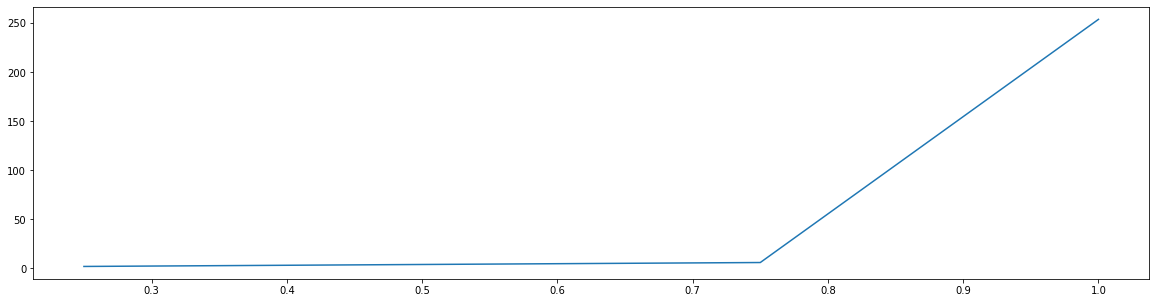

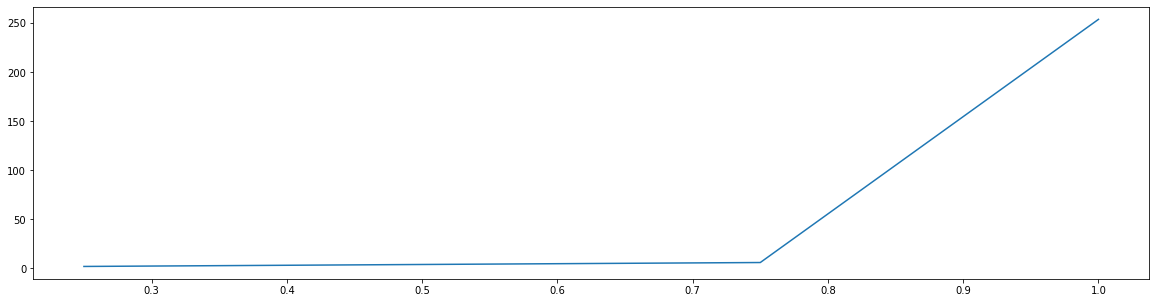

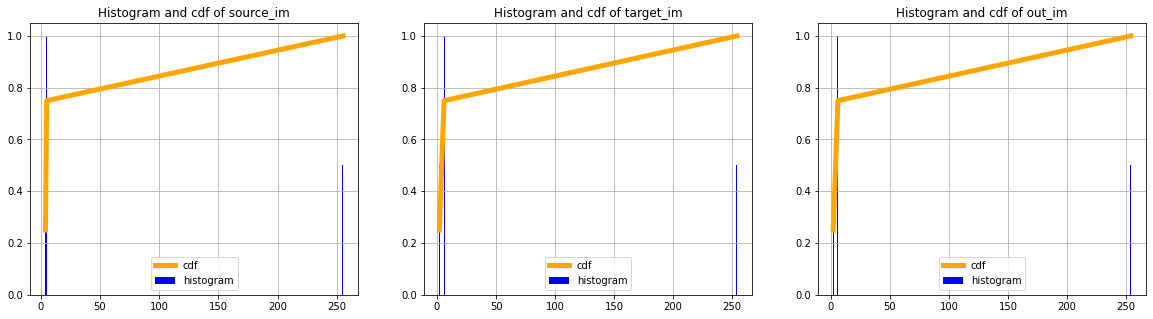

In [6]:
lena = np.array([[5,255],[4,5]])
img = np.array([[6,254],[2,6]])
print("Vstupný obraz: ",lena.ravel())
match_cdf2(lena,img);

## Testing match cdf for different sizes

Vstupný obraz:  [  5 255   9   4   5   2]
SOURCE unique values[  2   4   5   9 255], SOURCE unique indices[2 4 3 1 2 0]
Cdf of source: [0.16666667 0.33333333 0.66666667 0.83333333 1.        ]
Unique counts of source:[1 1 2 1 1]

TARGET unique values[  2   6 254], TARGET unique indices[1 2 1]
Cdf of target: [0.25 0.75 1.  ]
Unique counts of source:[1 2 1]

OUT unique values[  2   3   5  89 254]


<Figure size 432x288 with 0 Axes>

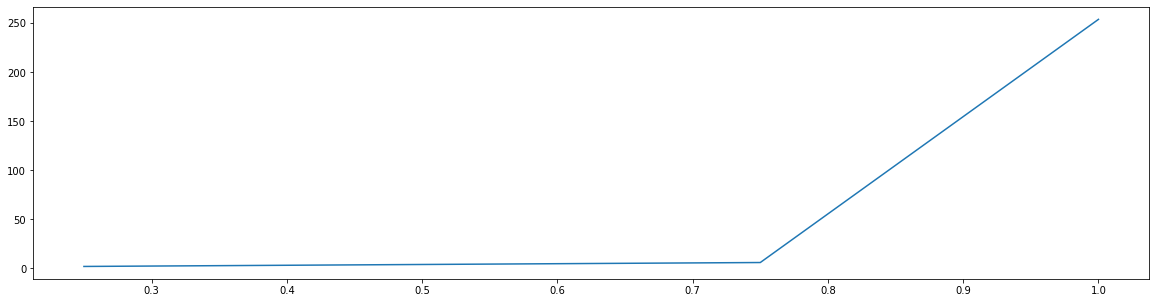

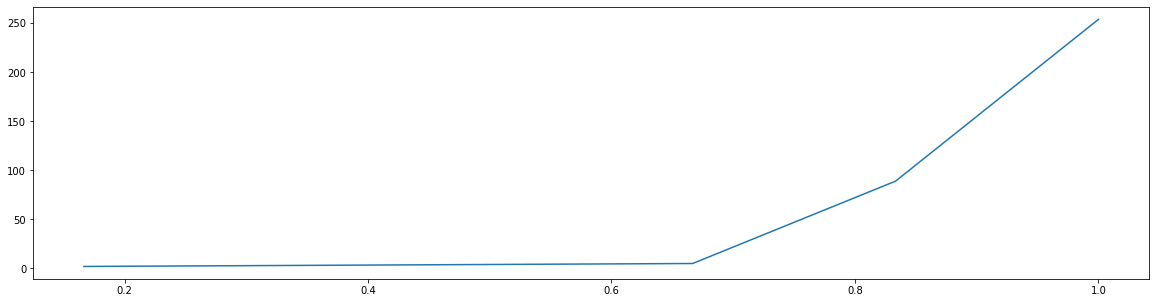

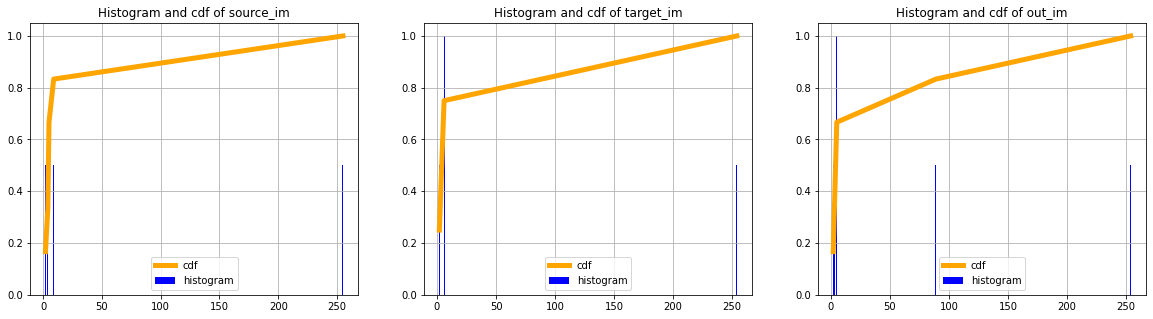

In [7]:
lena = np.array([[5,255,9],[4,5,2]])
img = np.array([[6,254],[2,6]])
print("Vstupný obraz: ",lena.ravel())
match_cdf2(lena,img);

# Hist_matching

In [8]:
def hist_matching(source_im,target_im,D):
    s_h,s_w = source_im.shape
    t_h,t_w = target_im.shape
    if source_im.dtype != np.uint8 or target_im.dtype != np.uint8:
        raise ValueError("Wrong input, source_im is np.uint8 and target_im is np.uint8")
    if s_h < D or s_w< D or t_h < D or t_w < D:
        print("Warning: D is greater than source or target image")
    if s_h%D or s_w%D:
        print("Warnnig: Source_dims/D is not whole number")
    if s_h < 1 or s_w < 1 or t_h < 1 or t_w < 1:
         raise ValueError("Wrong input array")
    
    s_Mask = (D,D)
    Dh_t_mask =D*t_h//s_h
    Dw_t_mask = D*t_w//s_w
    t_Mask =(Dh_t_mask,Dw_t_mask)
    y = math.ceil(s_h/D)
    x = math.ceil(s_w/D)

    #------------------------------------------------------PLOTTING--------------------------------------------

    for i in range(y):
        for j in range(x):
            plt.figure(figsize=(20,2))
            if s_Mask[1]*(i+1) > s_h and s_Mask[0]*(j+1) > s_w:
                s = slice(s_Mask[0]*i,-1)
                source_t = source_im[s_Mask[0]*i:-1,s_Mask[1]*j:-1]
                target_t = target_im[t_Mask[0]*j:-1,t_Mask[1]*j:-1]
                match_t = match_cdf(source_t,target_t)
                plots(source_t,target_t,match_t,1)
                    
            elif s_Mask[1]*(i+1) > s_h:
                source_t = source_im[s_Mask[0]*i:-1,s_Mask[1]*j:s_Mask[1]*(j+1)]
                target_t = target_im[t_Mask[0]*i:-1,t_Mask[1]*j:t_Mask[1]*(j+1)]
                match_t = match_cdf(source_t,target_t)
                plots(source_t,target_t,match_t,2)
                          
            elif s_Mask[0]*(j+1) > s_w:
                source_t = source_im[s_Mask[0]*i:s_Mask[0]*(i+1),s_Mask[1]*(j):-1]
                target_t = target_im[t_Mask[0]*i:t_Mask[0]*(i+1),t_Mask[1]*(j):-1]
                match_t = match_cdf(source_t,target_t)
                plots(source_t,target_t,match_t,3)
            else:
                source_t = source_im[s_Mask[0]*i:s_Mask[0]*(i+1),s_Mask[1]*j:s_Mask[1]*(j+1)]
                target_t = target_im[t_Mask[0]*i:t_Mask[0]*(i+1),t_Mask[1]*j:t_Mask[1]*(j+1)]
                match_t = match_cdf(source_t,target_t)
                plots(source_t,target_t,match_t,4)

#------------------------------------------Algorithm-------------------------------------------------------
    for i in range(y):
        for j in range(x):
            if s_Mask[1]*(i+1) > s_h and s_Mask[0]*(j+1) > s_w: # if mask is is out of picture width and height dimensions
                source_im[s_Mask[0]*i:-1,s_Mask[1]*j:-1] = match_cdf(
                source_im[s_Mask[0]*i:-1,s_Mask[1]*j:-1],
                target_im[t_Mask[0]*j:-1,t_Mask[1]*j:-1])
                
            elif s_Mask[1]*(i+1) > s_h: #if mask is is out of picture height dimension
                source_im[s_Mask[0]*i:-1,s_Mask[1]*j:s_Mask[1]*(j+1)] = match_cdf(
                source_im[s_Mask[0]*i:-1,s_Mask[1]*j:s_Mask[1]*(j+1)],
                target_im[t_Mask[0]*i:-1,t_Mask[1]*j:t_Mask[1]*(j+1)])
                          
            elif s_Mask[0]*(j+1) > s_w:# if mask is is out of picture width dimension
                 source_im[s_Mask[0]*i:s_Mask[0]*(i+1),s_Mask[1]*(j):-1] = match_cdf(
                 source_im[s_Mask[0]*i:s_Mask[0]*(i+1),s_Mask[1]*(j):-1],
                 target_im[t_Mask[0]*i:t_Mask[0]*(i+1),t_Mask[1]*(j):-1])

            else:
                source_im[s_Mask[0]*i:s_Mask[0]*(i+1),s_Mask[1]*j:s_Mask[1]*(j+1)]= match_cdf( # computing matching tile with source tile and target tile
                source_im[s_Mask[0]*i:s_Mask[0]*(i+1), s_Mask[1]*j:s_Mask[1]*(j+1)],#source tile with source Mask
                target_im[t_Mask[0]*i:t_Mask[0]*(i+1), t_Mask[1]*j:t_Mask[1]*(j+1)])#target tile with target Mask
    return source_im.astype(np.uint8)

def plots(source_t,target_t,match_t,x):
    subplot(1,5,1)
    plt.title("Source tile, source shape {}".format(source_t.shape))
    plt.imshow(source_t,cmap="gray")
    subplot(1,5,2)
    plt.title("Target tile, source shape {}".format(target_t.shape))
    plt.imshow(target_t,cmap="gray")
    subplot(1,5,3)
    plt.title("Source tile histogram")
    plt.hist(source_t.ravel(),bins=20,histtype="bar",color="green")
    subplot(1,5,4)
    plt.title("Target tile histogram")
    plt.hist(target_t.ravel(),bins=20,histtype="bar",color="red")
    subplot(1,5,5)
    plt.title("Match tile histogram")
    plt.hist(match_t.ravel(),bins=20,histtype="bar",color="blue")

## Test hist_match (D not fitting image)

Warnnig: Source_dims/D is not whole number


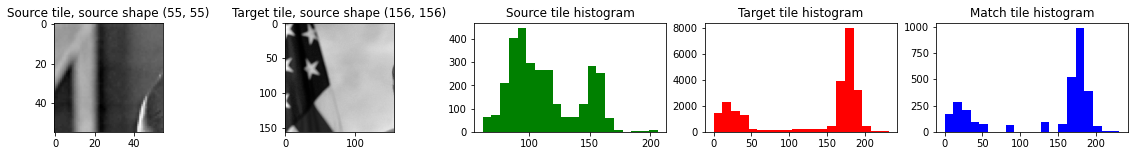

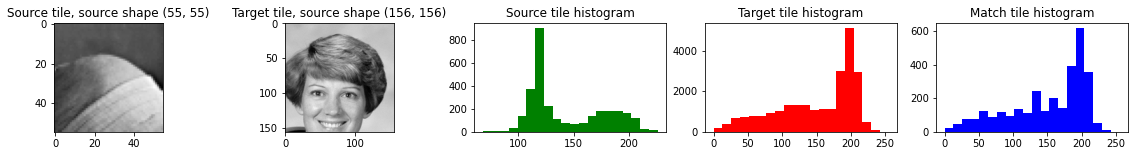

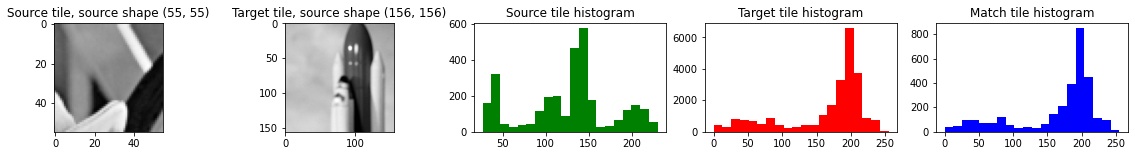

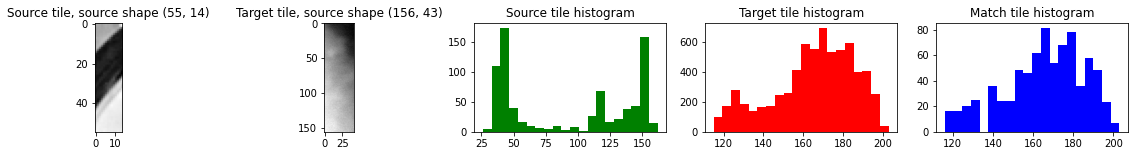

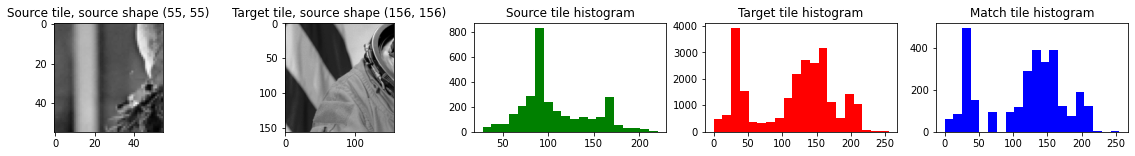

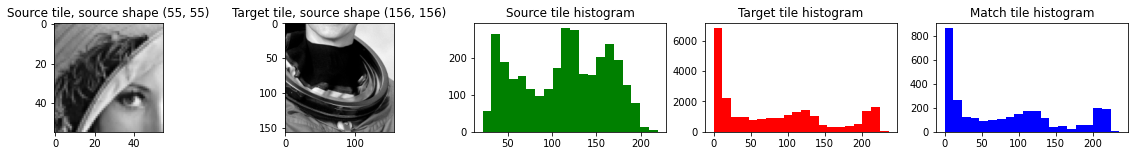

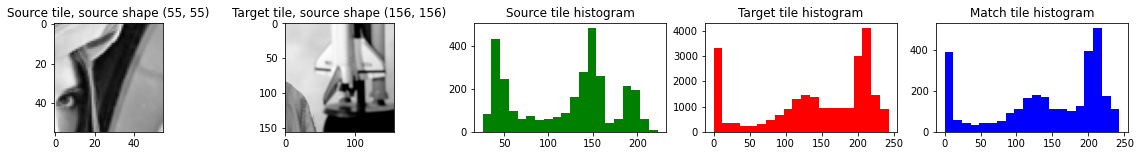

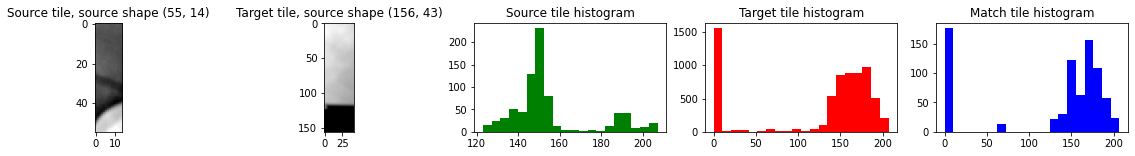

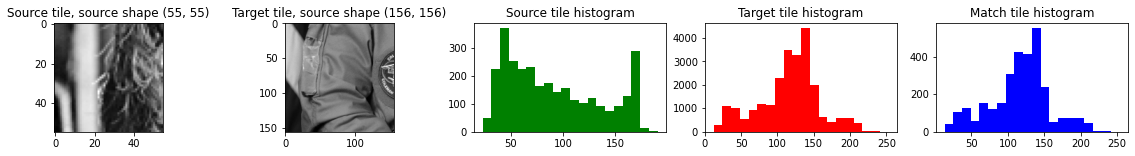

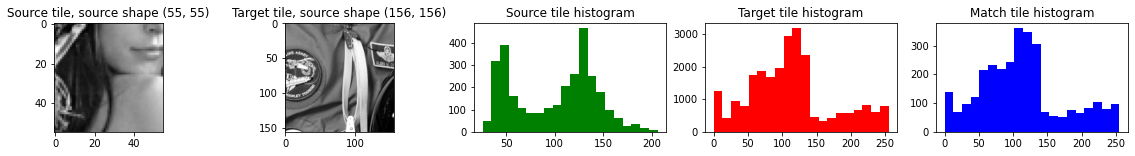

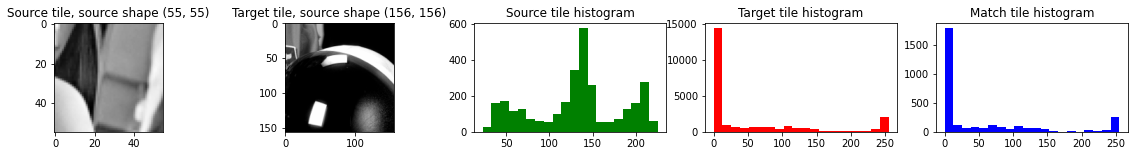

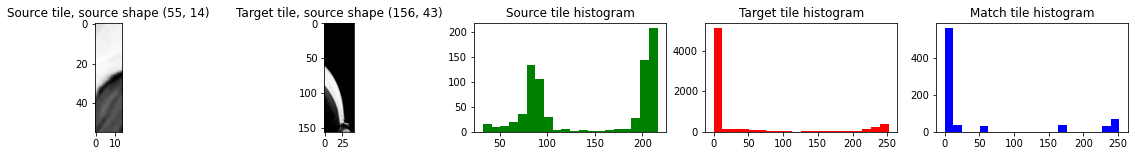

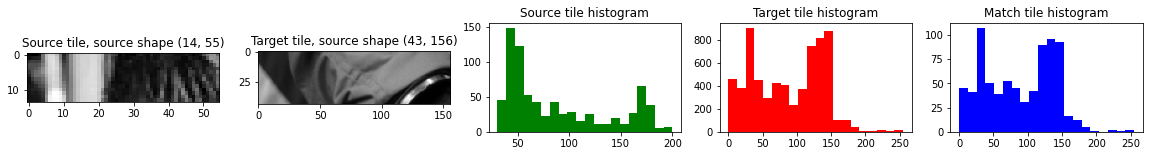

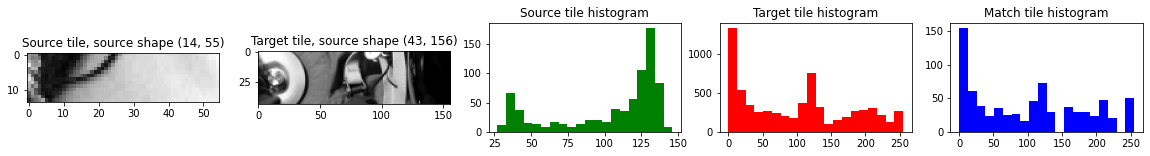

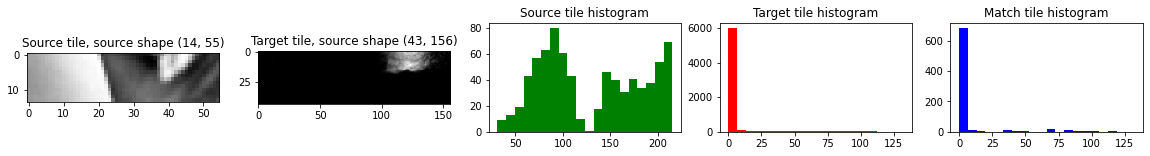

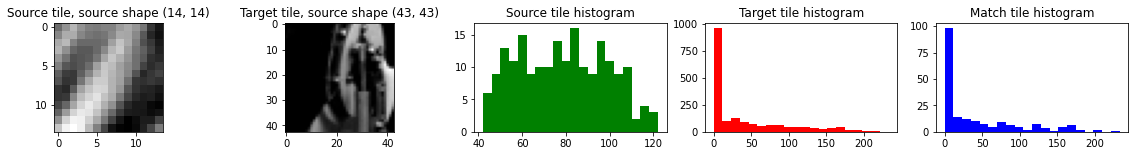

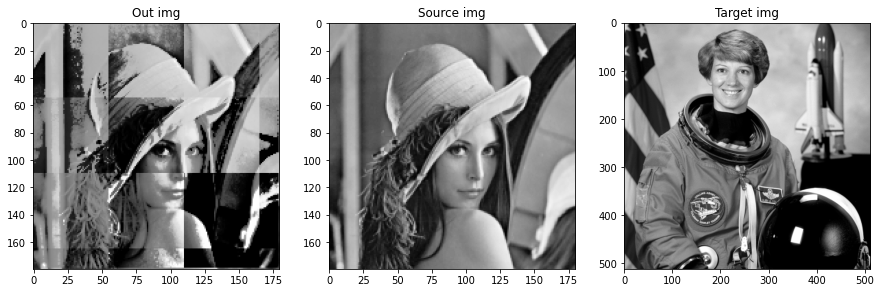

In [9]:
lena = io.imread(LennaPth,as_gray=True)
lenaCopy = io.imread(LennaPth,as_gray=True)

lena = transform.resize(lena,(180,180))
lenaCopy = transform.resize(lenaCopy,(180,180))

lena = lena*255
lena = lena.astype(np.uint8)

img =(rgb2gray(data.astronaut())*255).astype(np.uint8)

result = hist_matching(lena,img,55)
plt.figure(figsize=(15,10))
subplot(131)
plt.title("Out img")
plt.imshow(result,cmap="gray")
subplot(132)
plt.title("Source img")
plt.imshow(lenaCopy,cmap="gray")
subplot(133)
plt.title("Target img")
plt.imshow(img,cmap="gray")

## Testing hist_match (D fitting image)

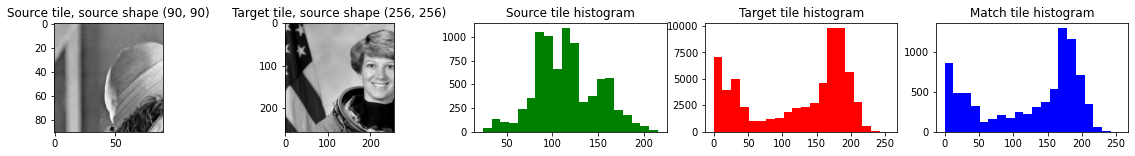

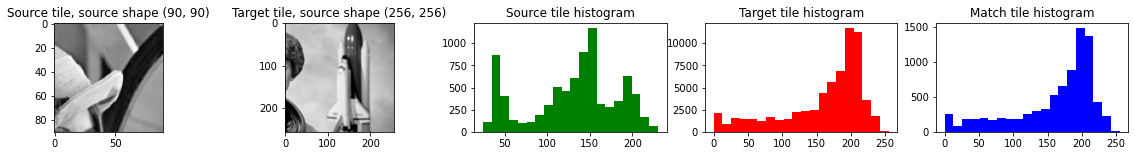

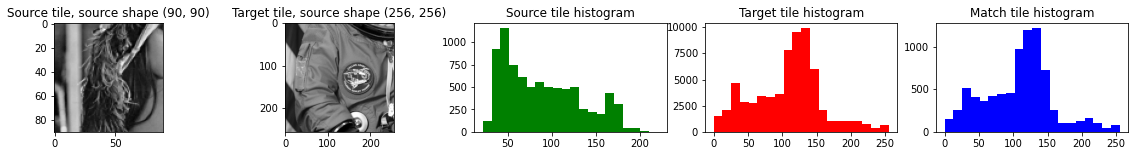

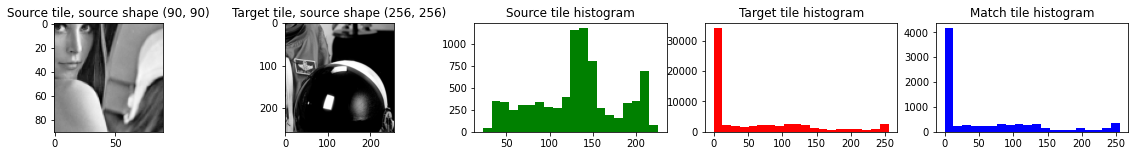

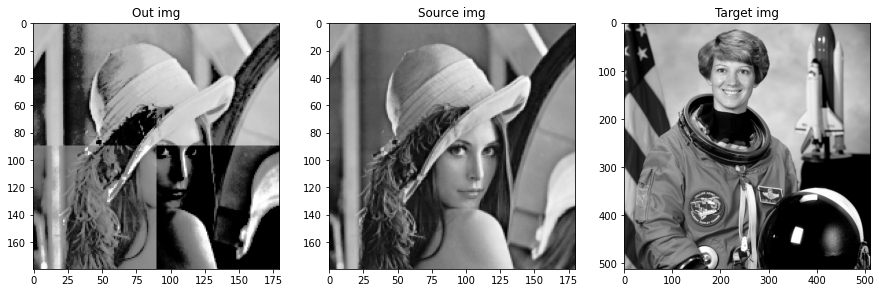

In [10]:
lena = io.imread(LennaPth,as_gray=True)
lenaCopy = io.imread(LennaPth,as_gray=True)
lenaCopy = transform.resize(lenaCopy,(180,180))
lena = transform.resize(lena,(180,180))
lena = lena*255
lena = lena.astype(np.uint8)

img =(rgb2gray(data.astronaut())*255).astype(np.uint8)

result = hist_matching(lena,img,90)
plt.figure(figsize=(15,10))
subplot(131)
plt.title("Out img")
plt.imshow(result,cmap="gray")
subplot(132)
plt.title("Source img")
plt.imshow(lenaCopy,cmap="gray")
subplot(133)
plt.title("Target img")
plt.imshow(img,cmap="gray")